In [17]:
import pandas as pd
import numpy as np

import pickle

import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTENC, SMOTE

from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, auc


Primero importamos nuevamente el dataset limpio y filtrado.

In [18]:
data = pd.read_csv('./data/bank_churners_filtered.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.dtypes

Attrition_Flag                int64
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [19]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
1,0,57,F,2,Graduate,Married,Less than $40K,Blue,48,5,2,2,2436.0,680,1756.0,1.190,1570,29,0.611,0.279
2,0,47,M,1,Doctorate,Divorced,$60K - $80K,Blue,42,5,2,0,20979.0,1800,19179.0,0.906,1178,27,0.929,0.086
3,1,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000
4,0,41,F,3,Graduate,Single,Less than $40K,Blue,28,6,1,2,7768.0,1669,6099.0,0.797,1051,22,0.833,0.215


# Funciones

In [20]:
# Funcion para mostrar metricas.
def model_metrics(y_train, y_pred_train, y_pred_train_proba, y_test, y_pred_test, y_pred_test_proba, plot_conf_mat=True):
    
    # ---METRICAS TRAIN---
    # Matriz de confusion con mis datos de entrenamiento.
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    
    # Obtengo los TN, FP, FN, TP de la matriz de confusion de entrenamiento.
    tn_train, fp_train, fn_train, tp_train = conf_matrix_train.ravel()
    
    # Obtengo metricas de train.
    acc_score_train = np.round(accuracy_score(y_train, y_pred_train),4)
    rec_score_train = np.round(recall_score(y_train, y_pred_train),4)
    prec_score_train = np.round(precision_score(y_train, y_pred_train),4)
    spec_score_train= np.round((tn_train / (tn_train + fp_train)),4)
    f_score_train = np.round(f1_score(y_train, y_pred_train),4)
    
    fpr_log_train, tpr_log_train, thr_log_train = roc_curve(y_train, y_pred_train_proba[:,1])
    auc_score_train = np.round(auc(fpr_log_train, tpr_log_train),4)
    
    # ---METRICAS TEST---
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    
    acc_score_test = np.round(accuracy_score(y_test, y_pred_test),4)
    rec_score_test = np.round(recall_score(y_test, y_pred_test),4)
    prec_score_test = np.round(precision_score(y_test, y_pred_test),4)
    spec_score_test= np.round((tn_test / (tn_test + fp_test)),4)
    f_score_test = np.round(f1_score(y_test, y_pred_test),4)
    
    fpr_log_test, tpr_log_test, thr_log_test = roc_curve(y_test, y_pred_test_proba[:,1])
    auc_score_test = np.round(auc(fpr_log_test, tpr_log_test),4)
    
    # Creo 2 filas, uno con los datos de train, otra con los datos de test. Y 5 columnas para las metricas.
    data_df = [
            [acc_score_train, rec_score_train, prec_score_train, spec_score_train, f_score_train, auc_score_train],
            [acc_score_test,  rec_score_test,  prec_score_test,  spec_score_test,  f_score_test,  auc_score_test]
            ]
    
    # Le doy nombre a las columnas.
    columns_df = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1-Score', 'AUC']

    # Creo DataFrame.
    data_result = pd.DataFrame(data_df, columns=columns_df, index=['Metricas Train', 'Metricas Test'])
    
    # Si se indica como algumento de la funcion, plotea la matriz de confusion.
    if plot_conf_mat:
        sns.heatmap(conf_matrix_test, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
        plt.xlabel('Valores Predichos')
        plt.ylabel('Valores Reales')
    
    # Devuelvo el DataFrame con las metricas.
    return data_result

In [21]:
# Funcion para graficar las metricas de los distintos modelos.
from operator import index


def plot_scores(scores, etiquetas_modelos):
    # Creo un Dataframe para agregar los scores.
    data_fun = pd.DataFrame(columns=['CV', 'Modelo', 'Score'])

    # Recorro el array de valores.
    # [ [ array1 ], [ array2 ], ..., [ arrayn ] ]
    for pos, array in enumerate(scores):
        # Creo contador para contar el numero de CV.
        contador_cv = 1
        # itero sobre los valores dentro de cada array.
        # [valor1, valor2, ..., valorn]
        for score in array:
            # Agrego los valores al dataframe.
            data_fun = data_fun.append({'CV' : contador_cv, 'Modelo' : etiquetas_modelos[pos],'Score' : score}, ignore_index=True)
            contador_cv += 1
    
    # Creamos la figura para plotear.
    # Grafico los distintos modelos.    
    fig = px.line(data_fun, x='CV', y='Score', color='Modelo')

    fig.update_layout(height=500, width=1000,title = 'Variacion de F1-Score CV', xaxis_title = 'CV', yaxis_title = 'F1-Score')
    fig.show()

# PipeLines

Pipeline es una serie de pasos automatizados para transformar los datos con el objetivo de asegurar su validez y consistencia. 

Cada paso se alimenta del paso previo.

Al ser reutilizables aseguran la consistencia en las operaciones, y al agrupar las mismas proveen un mayor nivel de abstraccion.

El esquema general para implementar pipeline es el que sigue:

- Construir la lista de pasos que se ejecutan en secuencia, cada paso es una tupla que contiene un nombre que se le da al paso y la instancia de un estimador.

- Instanciar pipeline con los pasos definidos.

- Entrenar la instancia de pipeline con los datos de entrenamiento.

- Evaluar el modelo generado.

Por lo tanto ahora vamos a crear los pasos que queremos que siga pipeline. Como habiamos dicho antes los pasos a considerar son:

1- Separar datos en entrenamiento y en test.

2- Escalar las variables continuas, para poder aplicar SMOTENC, ya que como se explico previamente SMOTE se basa en generar muestras mediante la distancia euclideana, y las variables necesitan estar escaladas.

3- Balance de clases, mediante SMOTENC.

4- Dumifico las variables categoricas.

5- Selecciono las features mas importantes utilizando SelectFromModel.

6- Entreno el modelo y evaluo como perform

Otra cosa a aclarar, ya que pipeline de scikit-learn no tolera el metodo fit_resample, el cual es un paso necesario para balancear las clases, utilizaremos pipeline de imbalanced-learn.

In [22]:
# Voy a obtener el nombre de mis columnas numericas y numericas, para pasarselas a ColumnTransformer.
num_cols_name = []
cat_cols_name = []

for col in data.iloc[:, 1:].columns:
    if data[col].dtype == 'object':
        cat_cols_name.append(col)
    
    else:
        num_cols_name.append(col)

# Sabemos que las columnas que 'ColumnTransformer' ignora se ubican ultimas en el array.
# Por lo tanto para obtener el indice de las columnas categoricas, para pasarselas a SMOTENC.
cat_index = [len(num_cols_name) + i for i, col in enumerate(cat_cols_name)]
print('Luego de escalar los datos mediante ColumnTransformer, el indice de las columnas categoricas sera', cat_index)

Luego de escalar los datos mediante ColumnTransformer, el indice de las columnas categoricas sera [14, 15, 16, 17, 18]


In [23]:
# Declaro mis features.
X = data.drop(columns='Attrition_Flag')

# Declaro mi variable target.
y = data['Attrition_Flag']

In [24]:
# Definimos los pasos.
# 1 - Separo en datos de entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=13)

# 2 - Escalo las variables continuas.
ct_scaler = ColumnTransformer([('scale', StandardScaler(), num_cols_name)], remainder='passthrough')

# 3 - Balanceo de clases.
sm = SMOTENC(categorical_features=cat_index, sampling_strategy='minority', random_state=13)

# 4 - Dumifico las variables categoricas.
ct_dummifier = ColumnTransformer([('ct_dummify', OneHotEncoder(drop='first'), cat_index)], remainder='passthrough')

# 5 -Selecciono las features mas importantes.
feature_selection = SelectFromModel(RandomForestClassifier(random_state=13), prefit=False, threshold='0.005*mean')

# 6 - Selecciono modelo para entrenar.
model = RandomForestClassifier(random_state=13)

# Instanciamos Pipeline, con los respectivos pasos.
rf_model_pipe = Pipeline(
    steps= [
        ('scaling', ct_scaler), 
        ('class_balance', sm),
        ('pipe_dumify', ct_dummifier),
        ('selectfrommodel', feature_selection),
        ('rf', model)
        ])

rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['Customer_Age',
                                                   'Dependent_count',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Amt',
                                         

Ahora probaremos prediciendo con los hiperparametros por defecto, para ver que tal performa el modelo.

,Accuracy,Recall,Precision,Specificity,F1-Score,AUC
Metricas Train,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Metricas Test,0.9555,0.8566,0.8664,0.9745,0.8615,0.9858


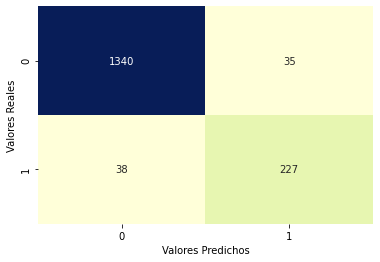

In [25]:
# Predicciones con datos de train.
y_pred_train = rf_model_pipe.predict(X_train)
y_pred_proba_train = rf_model_pipe.predict_proba(X_train)
# Predicciones con datos de test.
y_pred_test = rf_model_pipe.predict(X_test)
y_pred_proba_test = rf_model_pipe.predict_proba(X_test)

model_metrics(y_train, y_pred_train, y_pred_proba_train, y_test, y_pred_test, y_pred_proba_test)

<img src="img/modelo_selectfrommodel_overs.png" width=30% height=25%> <b> Modelo R.F. Oversample - SelectFromModel </b>

Podemos ver que con los hiperparametros por defecto, el modelo perfomo muy bien, mejor que con el modelo de prueba.

Ahora procederemos a aplicar GridSearchCV para setear distintos hiperparametros y mejorar aun mas el modelo.

# Pipeline + GridSearchCV

Gridsearch busca la mejor combinacion de hiperparametros dentro de una grilla especificada previamente. 

In [26]:
# Instanciamos Pipeline, con los respectivos pasos.
grid_pipe = Pipeline(
    steps= [
        ('scaling', ct_scaler), 
        ('class_balance', sm),
        ('pipe_dumify', ct_dummifier),
        ('selectfrommodel', feature_selection),
        ('rf', model)
        ])

# Creamos la grilla de hiperparametros.
grid_params = {
    'class_balance__k_neighbors' : [3,5,10],
    'selectfrommodel__threshold' : ['median', 'mean', '0.005*median'],
    'rf__n_estimators' : [50,100,150],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__max_depth' : [5,10,15,None],
    'rf__min_samples_split' : [2,3,5],
    'rf__min_samples_leaf' : [1,3]
}
# Determinamos la estrategia de cross-validation que vamos a usar.
grid_cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=13)

clf = GridSearchCV(grid_pipe, grid_params, cv=grid_cv, scoring='f1')
# Comentado para que no se ejecute, se cargara luego mediante pickle.
#clf.fit(X_train, y_train)
#clf.best_params_

Los mejores parametros fueron

<img src="img/best_params.png" width=30% height=25%>

Ahora vamos a bajar a disco el objeto que tiene el modelo entrenado. Vamos a guardar un archivo meiante pickle, ya que tardo 2:30 horas en fitear el modelo, y no queremos esperar tanto entre ejecucion y ejecucion.

<img src="img/time_gridsearch.png" width=30% height=25%>

In [27]:
if os.path.isfile('./models/bank_churn_model_gridsearch.pkl'):
    with open('./models/bank_churn_model_gridsearch.pkl', 'rb') as f_model:
        grid_search_model = pickle.load(f_model)
else:
    with open('./models/bank_churn_model_gridsearch.pkl', 'wb') as f_model:
        pickle.dump(clf, f_model)

,Accuracy,Recall,Precision,Specificity,F1-Score,AUC
Metricas Train,0.9998,1.0000,0.9987,0.9998,0.9994,1.0000
Metricas Test,0.9585,0.8717,0.8717,0.9753,0.8717,0.9863


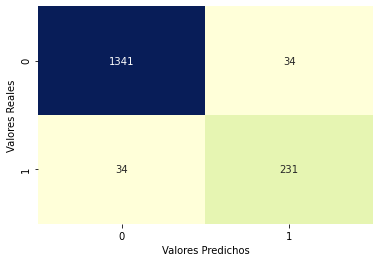

In [28]:
# Predicciones con datos de train.
y_pred_train = grid_search_model.predict(X_train)
y_pred_proba_train = grid_search_model.predict_proba(X_train)
# Predicciones con datos de test.
y_pred_test = grid_search_model.predict(X_test)
y_pred_proba_test = grid_search_model.predict_proba(X_test)

model_metrics(y_train, y_pred_train, y_pred_proba_train, y_test, y_pred_test, y_pred_proba_test)

Con las metricas obtenidas podemos comparar los dos modelos, podemos ver que  en general las metricas mejoraron, a no ser por F1-score y precision que bajaron levemente. 

Al aplicar grid search, obtuvmimos un modelo mas balanceado que el anterior. Pero en este caso optaremos por quedarnos con el modelo anterior ya que nos interesa predecir que cliente abndonara el banco para tratar de convencerlo de que no lo haga.

# Comparacion de distintos modelos de prediccion.

Ahora probaremos mediante otros modelos para ver cual es el que mejor performa, utilizaremos unicamente la metrica F1, haciendo cross validation.

In [29]:
from xgboost import XGBClassifier
# primero establecemos los pasos de cada modelo.
# Instanciamos Pipeline, con los respectivos pasos.
lr_model_pipe = Pipeline(
    steps= [
        ('scaling', ct_scaler), 
        ('class_balance', sm),
        ('pipe_dumify', ct_dummifier),
        ('selectfrommodel', feature_selection),
        ('lr', LogisticRegression(C=1e10, max_iter=200))
        ])

ada_model_pipe = Pipeline(
    steps= [
        ('scaling', ct_scaler), 
        ('class_balance', sm),
        ('pipe_dumify', ct_dummifier),
        ('selectfrommodel', feature_selection),
        ('adab', AdaBoostClassifier(random_state=13))
        ])

xgb_model_pipe = Pipeline(
    steps= [
        ('scaling', ct_scaler), 
        ('class_balance', sm),
        ('pipe_dumify', ct_dummifier),
        ('selectfrommodel', feature_selection),
        ('xgb', XGBClassifier(random_state=13))
        ])

rf_f1_cross_val_score = cross_val_score(rf_model_pipe, X_train, y_train, cv=5, scoring='f1')
lr_f1_cross_val_score = cross_val_score(lr_model_pipe, X_train, y_train, cv=5, scoring='f1')
ada_f1_cross_val_score = cross_val_score(ada_model_pipe, X_train, y_train, cv=5, scoring='f1')
xgb_f1_cross_val_score = cross_val_score(xgb_model_pipe, X_train, y_train, cv=5, scoring='f1')

In [30]:
scores = [rf_f1_cross_val_score, lr_f1_cross_val_score, ada_f1_cross_val_score, xgb_f1_cross_val_score]
etiquetas = ['Random Forest', 'Regresion Logistica', 'AdaBoost', 'XGBoost']
plot_scores(scores, etiquetas)

De este grafico puede verse que el mejor modelo como antes, sigue siendo XGBoost, luego le continua RandomForest, por lo tanto podemos decir que la aplicacion de feature engineer funcino, para mejorar el modelo.

Por lo tanto guardaremos el modelo de XGBoost en el disco para poder deployarlo.

,Accuracy,Recall,Precision,Specificity,F1-Score,AUC
Metricas Train,1.000,1.0000,1.0000,1.0000,1.0000,1.0000
Metricas Test,0.972,0.9245,0.9041,0.9811,0.9142,0.9894


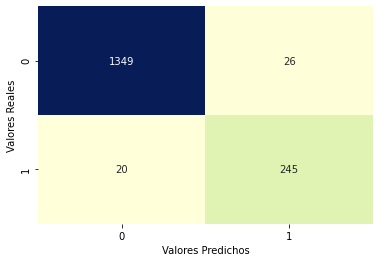

In [31]:
# fiteamos el modelo.
xgb_model_pipe.fit(X_train, y_train)

# Predicciones con datos de train.
y_pred_train = xgb_model_pipe.predict(X_train)
y_pred_proba_train = xgb_model_pipe.predict_proba(X_train)
# Predicciones con datos de test.
y_pred_test = xgb_model_pipe.predict(X_test)
y_pred_proba_test = xgb_model_pipe.predict_proba(X_test)

model_metrics(y_train, y_pred_train, y_pred_proba_train, y_test, y_pred_test, y_pred_proba_test)

In [32]:
if os.path.isfile('./models/bank_churn_final_model.pkl'):
    with open('./models/bank_churn_final_model.pkl', 'rb') as f_model:
        grid_search_model = pickle.load(f_model)
else:
    with open('./models/bank_churn_final_model.pkl', 'wb') as f_model:
        pickle.dump(xgb_model_pipe, f_model)

Veremos ahora que columnas fueron seleccionadas por SelectKBest y el orden en el que estas quedaron. Para poder pasarle las features y asi generar la prediccion en la parte de deploy.

In [33]:
# Primero se ubicaran las columnas categoricas.
model_cols = xgb_model_pipe['pipe_dumify'].transformers_[0][1].get_feature_names().tolist()

# Luego agrego las columnas numericas.
for i in xgb_model_pipe['scaling'].transformers_[0][2]:
    model_cols.append(i)

In [34]:
mask = xgb_model_pipe['selectfrommodel'].get_support()
array = np.array(model_cols)
array[mask]

array(['x0_M', 'x1_Doctorate', 'x1_Graduate', 'x1_High School',
       'x1_Post-Graduate', 'x1_Uneducated', 'x2_Married', 'x2_Single',
       'x3_$40K - $60K', 'x3_$60K - $80K', 'x3_$80K - $120K',
       'x3_Less than $40K', 'x4_Gold', 'x4_Silver', 'Customer_Age',
       'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio'], dtype='<U24')